In [7]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [9]:
!pip install livelossplot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

import inspect
from tqdm import tqdm
#from keras.layers import LSTM

import efficientnet.keras as efn
from google.colab import drive
drive.mount('/gdrive/',force_remount=True)

Mounted at /gdrive/


In [ ]:
# Convolutional Neural Network

# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

In [13]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "/gdrive/MyDrive/Data Set/model/cnn_resenet_model.h5"
WEIGHT_FILE="/gdrive/MyDrive/Data Set/model/cnn_resenet_weight.h5"

# Data
path = "/gdrive/MyDrive/Data Set/MelData/"
training_data_dir = path + "eval" 
validation_data_dir = path + "dev" 
test_data_dir = path + "train" # 12 500

In [3]:
# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 64
TEST_SIZE = 30
num_classes=2

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [4]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "genuine_vs_spoof.h5"

# Data
path = "/gdrive/MyDrive/Data Set/MelData/"
training_data_dir = path + "eval" 
validation_data_dir = path + "dev" 
test_data_dir = path + "train" # 12 500

In [ ]:
base_model= tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling= 'avg',
    classes=1000,
    classifier_activation="softmax",
)

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale = 1./255,
                                            #shear_range = 0.2,
                                            #zoom_range = 0.2,
                                            #horizontal_flip = True,
                                             )
validation_data_generator = ImageDataGenerator(rescale=1./255 )
test_data_generator = ImageDataGenerator(rescale=1./255)

In [11]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode="categorical")

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=False,
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode="categorical")

Found 13305 images belonging to 2 classes.
Found 1710 images belonging to 2 classes.
Found 3014 images belonging to 2 classes.


spoof=0.55
genuine=5.13

In [ ]:
training_generator.class_indices

{'genuine': 0, 'spoofed': 1}

In [ ]:
class_weight = {0: 5.13,
                1: .55}

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import numpy as np


In [ ]:
checkpoint=keras.callbacks.ModelCheckpoint(WEIGHT_FILE,save_best_only=True,monitor='val_accuracy',mode='max')
#monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
base_model.trainable = True
#for layer in base_model.layers[:-5]:
 #   layer.trainable = False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
#model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(lr=0.0001))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_28 (Flatten)        (None, 512)               0         
                                                                 
 batch_normalization_29 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_29 (Dropout)        (None, 512)               0         
                                                                 
 dense_67 (Dense)            (None, 256)               131328    
                                                                 
 dense_68 (Dense)            (None, 2)                 514       
                                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
207/207 [==============================] - 2369s 11s/step - loss: 0.3401 - accuracy: 0.8938 - val_loss: 6.5547 - val_accuracy: 0.5541
Epoch 2/20
207/207 [==============================] - 2348s 11s/step - loss: 0.2527 - accuracy: 0.9030 - val_loss: 1.7064 - val_accuracy: 0.5559
Epoch 3/20
207/207 [==============================] - 2352s 11s/step - loss: 0.2050 - accuracy: 0.9122 - val_loss: 2.0017 - val_accuracy: 0.4567
Epoch 4/20
207/207 [==============================] - 2355s 11s/step - loss: 0.1797 - accuracy: 0.9203 - val_loss: 0.3748 - val_accuracy: 0.8233
Epoch 5/20
207/207 [==============================] - 2340s 11s/step - loss: 0.1525 - accuracy: 0.9332 - val_loss: 0.5339 - val_accuracy: 0.7013
Epoch 6/20
207/207 [==============================] - 2336s 11s/step - loss: 0.1360 - accuracy: 0.9412 - val_loss: 0.3809 - val_accuracy: 0.8185
Epoch 7/20
207/207 [==============================] - 2327s 11s/step - loss: 0.1278 - accuracy: 0.9450 - val_loss: 0.2177 - val_ac

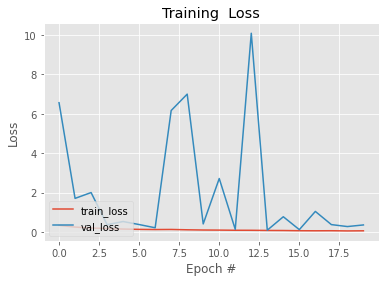

In [ ]:
H = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    #class_weight=class_weight,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[checkpoint]
)
model.save_weights(MODEL_FILE)
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#N = stopping.stopped_epoch + 1
plt.plot( H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.title("Training  Loss")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [15]:
from pickle import dump
import tensorflow as tf
in_model=tf.keras.models.load_model(WEIGHT_FILE)

in_model.load_weights(WEIGHT_FILE)
predicted_classes = in_model.predict(test_generator)

In [16]:
import numpy as np
classes=[]
for i in predicted_classes:
  
  if i[1]>0.5:
    classes.append(1)
  else:
    classes.append(0)
    #classes.append(np.argmax(i))

[Text(0, 0.5, 'Spoof'), Text(0, 1.5, 'Genuine')]

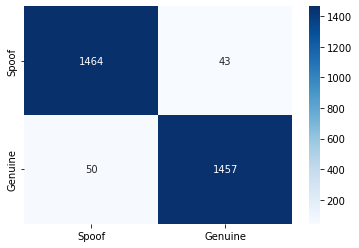

In [17]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

ax= plt.subplot()
sns.heatmap(confusion_matrix(test_generator.classes, classes),annot=True,cmap='Blues', fmt='g',ax=ax)

ax.xaxis.set_ticklabels(['Spoof', 'Genuine'])
ax.yaxis.set_ticklabels(['Spoof', 'Genuine'])